In [1]:
import math
import numpy as np
import numpy.random as nr
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from __future__ import print_function
from time import time
import logging
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# PCA (Tutorial)

http://scikit-learn.org/stable/auto_examples/applications/face_recognition.html

In [2]:
X, y = np.load('X_train.npy'), np.load('y_train.npy')

Z = np.load('X_test.npy')

n_samples, h, w = X.shape[0], 50, 37
target_names = range(7)
n_classes = 7

In [3]:
def pca_grid_search_svm(X, y, n_components = 150, random_state = 3244):
    
    # validation set
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=random_state)
    print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
    t0 = time()
    pca = PCA(n_components=n_components, svd_solver='randomized',
              whiten=True).fit(X_train)
    print("done in %0.3fs" % (time() - t0))
    
    # tranform train and test data
    print("Projecting the input data on the eigenfaces orthonormal basis")
    t0 = time()
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    print("done in %0.3fs" % (time() - t0))
    
    # grid search to tune hyper-paramters
    print("Fitting the classifier to the training set")
    t0 = time()
    param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
                  'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], 
                  'kernel': ['rbf']}
    clf = GridSearchCV(SVC(class_weight='balanced'), param_grid, scoring='f1_micro')
    clf = clf.fit(X_train_pca, y_train)
    print("done in %0.3fs" % (time() - t0))
    print("Best estimator found by grid search:")
    print(clf.best_estimator_)
    
    # test on test data
    print("Predicting people's names on the test set")
    t0 = time()
    y_pred = clf.predict(X_test_pca)
    print("done in %0.3fs" % (time() - t0))

    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))
    
    return (pca, clf)

In [4]:
def print_labels_to_file(filename, labels):
    fo = open(filename,'w')
    fo.write('ImageId,PredictedClass\n')
    for i in range(labels.shape[0]):
        fo.write(str(i) + ',' + str(labels[i])+'\n')
    fo.close()

In [5]:
pca, clf = pca_grid_search_svm(X, y)

Extracting the top 150 eigenfaces from 724 faces
done in 0.412s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.060s
Fitting the classifier to the training set
done in 23.124s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting people's names on the test set
done in 0.054s
             precision    recall  f1-score   support

          0       0.71      0.83      0.77        12
          1       0.80      0.85      0.83        48
          2       0.78      0.78      0.78        18
          3       0.87      0.89      0.88        98
          4       0.74      0.74      0.74        19
          5       0.85      0.69      0.76        16
          6       0.85      0.74      0.79        31

avg / total       0.83      0.83      0.83      

In [6]:
# fit to X, y
X_pca = pca.transform(X)
clf.fit(X_pca, y)

# print labels for test set
Z_pca = pca.transform(Z)
z_pred = clf.predict(Z_pca)
print_labels_to_file('pca_fit_to_X.csv', z_pred)

# With transformation
https://medium.com/@ageitgey/machine-learning-is-fun-part-4-modern-face-recognition-with-deep-learning-c3cffc121d78#.kz0cyt8sv
http://www.learnopencv.com/average-face-opencv-c-python-tutorial/

In [7]:
import dlib
import cv2

In [8]:
# get file from http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
predictor_model = "shape_predictor_68_face_landmarks.dat"
face_detector = dlib.get_frontal_face_detector()
face_pose_predictor = dlib.shape_predictor(predictor_model)

In [9]:
# from http://www.learnopencv.com/average-face-opencv-c-python-tutorial/

# Compute similarity transform given two sets of two points.
# OpenCV requires 3 pairs of corresponding points.
# We are faking the third one.

def similarityTransform(inPoints, outPoints) :
    s60 = math.sin(60*math.pi/180);
    c60 = math.cos(60*math.pi/180);  
    inPts = np.copy(inPoints).tolist();
    outPts = np.copy(outPoints).tolist();
    xin = c60*(inPts[0][0] - inPts[1][0]) - s60*(inPts[0][1] - inPts[1][1]) + inPts[1][0];
    yin = s60*(inPts[0][0] - inPts[1][0]) + c60*(inPts[0][1] - inPts[1][1]) + inPts[1][1];
    inPts.append([np.int(xin), np.int(yin)]);
    xout = c60*(outPts[0][0] - outPts[1][0]) - s60*(outPts[0][1] - outPts[1][1]) + outPts[1][0];
    yout = s60*(outPts[0][0] - outPts[1][0]) + c60*(outPts[0][1] - outPts[1][1]) + outPts[1][1];
    outPts.append([np.int(xout), np.int(yout)]);
    tform = cv2.estimateRigidTransform(np.array([inPts]), np.array([outPts]), False);
    return tform;

# Check if a point is inside a rectangle
def rectContains(rect, point) :
    if point[0] < rect[0] :
        return False
    elif point[1] < rect[1] :
        return False
    elif point[0] > rect[2] :
        return False
    elif point[1] > rect[3] :
        return False
    return True

# Calculate delanauy triangle
def calculateDelaunayTriangles(rect, points):
    # Create subdiv
    subdiv = cv2.Subdiv2D(rect);
    # Insert points into subdiv
    for p in points:
        subdiv.insert((p[0], p[1]));
    # List of triangles. Each triangle is a list of 3 points ( 6 numbers )
    triangleList = subdiv.getTriangleList();
    # Find the indices of triangles in the points array
    delaunayTri = []
    for t in triangleList:
        pt = []
        pt.append((t[0], t[1]))
        pt.append((t[2], t[3]))
        pt.append((t[4], t[5]))
        pt1 = (t[0], t[1])
        pt2 = (t[2], t[3])
        pt3 = (t[4], t[5])        
        if rectContains(rect, pt1) and rectContains(rect, pt2) and rectContains(rect, pt3):
            ind = []
            for j in xrange(0, 3):
                for k in xrange(0, len(points)):                    
                    if(abs(pt[j][0] - points[k][0]) < 1.0 and abs(pt[j][1] - points[k][1]) < 1.0):
                        ind.append(k)                            
            if len(ind) == 3:                                                
                delaunayTri.append((ind[0], ind[1], ind[2]))
    return delaunayTri


def constrainPoint(p, w, h) :
    p =  ( min( max( p[0], 0 ) , w - 1 ) , min( max( p[1], 0 ) , h - 1 ) )
    return p;

# Apply affine transform calculated using srcTri and dstTri to src and
# output an image of size.
def applyAffineTransform(src, srcTri, dstTri, size) :
    
    # Given a pair of triangles, find the affine transform.
    warpMat = cv2.getAffineTransform( np.float32(srcTri), np.float32(dstTri) )
    # Apply the Affine Transform just found to the src image
    dst = cv2.warpAffine( src, warpMat, (size[0], size[1]), None, flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101 )
    return dst


# Warps and alpha blends triangular regions from img1 and img2 to img
def warpTriangle(img1, img2, t1, t2) :

    # Find bounding rectangle for each triangle
    r1 = cv2.boundingRect(np.float32([t1]))
    r2 = cv2.boundingRect(np.float32([t2]))
    # Offset points by left top corner of the respective rectangles
    t1Rect = [] 
    t2Rect = []
    t2RectInt = []
    for i in xrange(0, 3):
        t1Rect.append(((t1[i][0] - r1[0]),(t1[i][1] - r1[1])))
        t2Rect.append(((t2[i][0] - r2[0]),(t2[i][1] - r2[1])))
        t2RectInt.append(((t2[i][0] - r2[0]),(t2[i][1] - r2[1])))
    # Get mask by filling triangle
    mask = np.zeros((r2[3], r2[2], 3), dtype = np.float32)
    cv2.fillConvexPoly(mask, np.int32(t2RectInt), (1.0, 1.0, 1.0), 16, 0);
    # Apply warpImage to small rectangular patches
    img1Rect = img1[r1[1]:r1[1] + r1[3], r1[0]:r1[0] + r1[2]]
    size = (r2[2], r2[3])
    img2Rect = applyAffineTransform(img1Rect, t1Rect, t2Rect, size)
    img2Rect = img2Rect * mask
    # Copy triangular region of the rectangular patch to the output image
    img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] * ( (1.0, 1.0, 1.0) - mask )
    img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] + img2Rect


In [10]:
def get_points(flat_images, h=h, w=w):
    points = []
    for i in range(len(flat_images)):
        image = np.uint8(flat_images[i].reshape((h,w)))
        points.append([])
        detected_faces = face_detector(image, 1)
        for j, face_rect in enumerate(detected_faces):
            pose_landmarks = face_pose_predictor(image, face_rect)
            for k in range(68): 
                point = dlib.full_object_detection.part(pose_landmarks, k)
                points[i].append((point.x, point.y))
            break
    return points

In [11]:
# adapted from http://www.learnopencv.com/average-face-opencv-c-python-tutorial/
# align eye corners at 0.3h, 0.15w/0.85w
def align_eyes(allPoints, images, h=h, w=w, n=68):
    # Eye corners
    eyecornerDst = [ (np.int(0.15 * w ), np.int(h / 3)), (np.int(0.85 * w ), np.int(h / 3)) ];
    imagesNorm = [];
    pointsNorm = [];
    # Add boundary points for delaunay triangulation
    boundaryPts = np.array([(0,0), (w/2,0), (w-1,0), (w-1,h/2), ( w-1, h-1 ), ( w/2, h-1 ), (0, h-1), (0,h/2) ]);    
    # Initialize location of average points to 0s
    pointsAvg = np.array([(0,0)]* ( n + len(boundaryPts) ), np.float32());
    numImages = len(images)
    numCount = 0
    # Warp images and trasnform landmarks to output coordinate system,
    # and find average of transformed landmarks.  
    for i in range(numImages):
        points1 = allPoints[i];
        # dont change image if no face detected
        if len(allPoints[i]) == 0:
            imagesNorm.append(images[i])
            pointsNorm.append([])
            continue;
        # Corners of the eye in input image
        eyecornerSrc  = [ allPoints[i][36], allPoints[i][45] ] ;
        # Compute similarity transform
        tform = similarityTransform(eyecornerSrc, eyecornerDst);
        # Apply similarity transformation
        img = cv2.warpAffine(images[i], tform, (w,h));
        # Apply similarity transform on points        
        points2 = np.reshape(np.array(points1), (68,1,2));        
        points = cv2.transform(points2, tform);
        points = np.float32(np.reshape(points, (68, 2)));
        # Append boundary points. Will be used in Delaunay Triangulation
        points = np.append(points, boundaryPts, axis=0)
        # Calculate location of average landmark points.
        numCount = numCount + 1
        pointsAvg = pointsAvg + points
        pointsNorm.append(points);
        imagesNorm.append(img);
    pointsAvg = pointsAvg/numCount
    return (imagesNorm, pointsNorm, pointsAvg)

In [12]:
def to_image(flat_images):
    return [img.reshape((h,w)) for img in flat_images]

def image_to_np_array(images, h=h, w=w):
    array = np.zeros((len(images), h*w))
    for k in range(len(images)):
        for i in range(h):
            for j in range(w):
                array[k][i*37+j] = images[k][i][j]
    return array

In [13]:
def plot_gallery(images, titles, h=h, w=w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i], cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

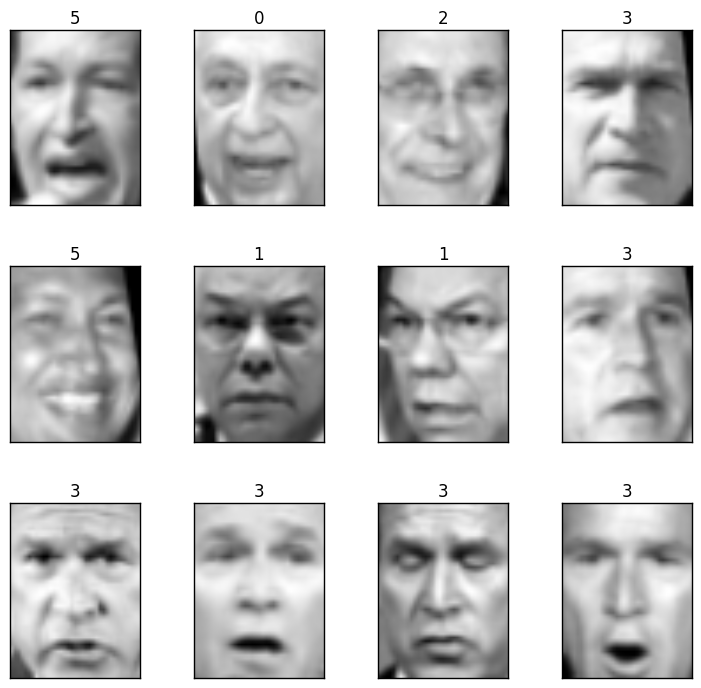

In [14]:
X_points = get_points(X)

X_images_norm = align_eyes(X_points, to_image(X))[0]

# testing rotation and alignment
plot_gallery(X_images_norm, y)
plt.show()

In [15]:
X_align = image_to_np_array(X_images_norm)
pca, clf = pca_grid_search_svm(X_align, y)

Extracting the top 150 eigenfaces from 724 faces
done in 0.343s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.036s
Fitting the classifier to the training set
done in 18.988s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting people's names on the test set
done in 0.030s
             precision    recall  f1-score   support

          0       0.71      0.83      0.77        12
          1       0.86      0.90      0.88        48
          2       0.76      0.89      0.82        18
          3       0.91      0.90      0.90        98
          4       0.78      0.74      0.76        19
          5       0.86      0.75      0.80        16
          6       0.93      0.84      0.88        31

avg / total       0.87      0.86      0.86      

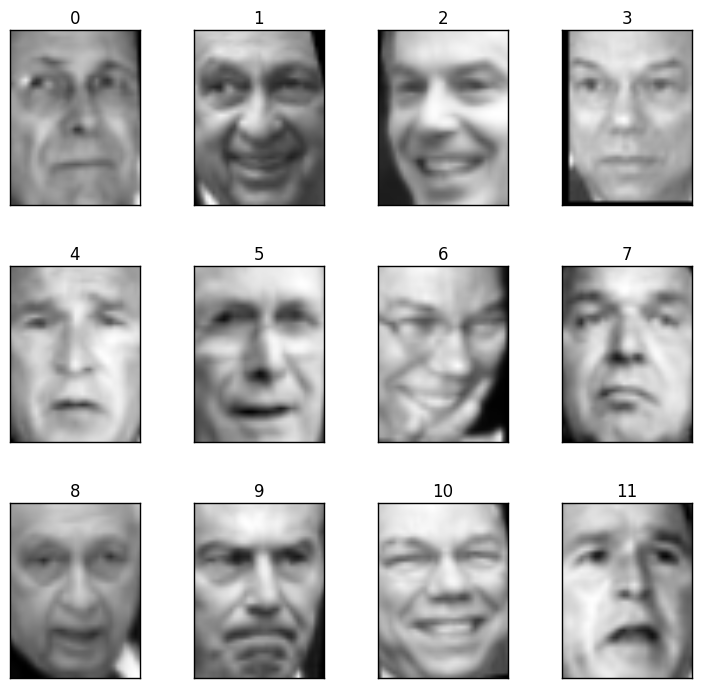

In [16]:
Z_points = get_points(Z)
Z_images_norm = align_eyes(Z_points, to_image(Z))[0]
Z_align = image_to_np_array(Z_images_norm)
# testing rotation and alignment
plot_gallery(Z_images_norm, range(len(Z_points)))
plt.show()

# fit to X, y
X_pca = pca.transform(X_align)
clf.fit(X_pca, y)
# print labels for test set
Z_pca = pca.transform(Z_align)
z_pred = clf.predict(Z_pca)
print_labels_to_file('transform_pca_fit_to_X.csv', z_pred)

# Testing without PCA & transformation

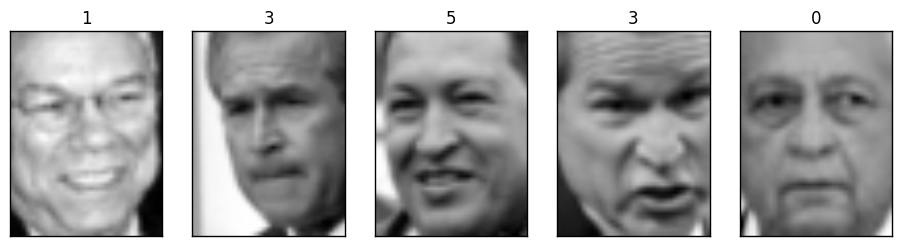

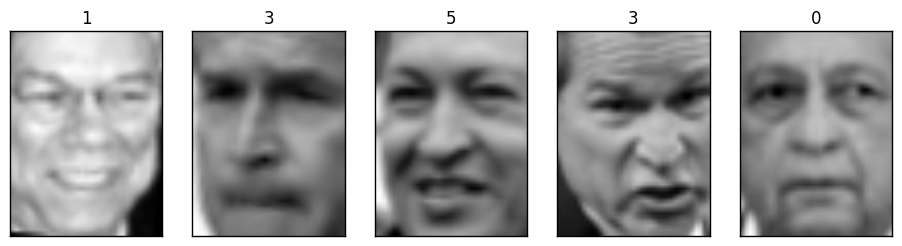

In [17]:
# to see diff between aligned and unaligned
plot_gallery(to_image(X[-10:]), y[-10:], n_row=1, n_col=5)
plot_gallery(to_image(X_images_norm[-10:]), y[-10:], n_row=1, n_col=5)
plt.show()

In [18]:
# validation set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=3244)
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'kernel': ['poly'], 
              'degree': [1, 2, 3],
              'coef0' : [0, 1, 2]}
clf = GridSearchCV(SVC(class_weight='balanced'), param_grid, scoring='f1_micro')
clf = clf.fit(X_train, y_train)
print("Best estimator found by grid search:")
print(clf.best_estimator_)


Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0,
  decision_function_shape=None, degree=1, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [ ]:
# test on test data
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

Predicting people's names on the test set
done in 0.446s
             precision    recall  f1-score   support

          0       0.75      1.00      0.86        12
          1       0.85      0.85      0.85        48
          2       0.68      0.72      0.70        18
          3       0.90      0.84      0.87        98
          4       0.63      0.63      0.63        19
          5       0.91      0.62      0.74        16
          6       0.71      0.87      0.78        31

avg / total       0.82      0.81      0.81       242

[[12  0  0  0  0  0  0]
 [ 1 41  1  2  0  0  3]
 [ 1  1 13  1  1  0  1]
 [ 1  3  4 82  3  1  4]
 [ 1  2  1  2 12  0  1]
 [ 0  0  0  1  3 10  2]
 [ 0  1  0  3  0  0 27]]


In [ ]:
clf.fit(X,y)
print_labels_to_file('poly_fit_to_X.csv', clf.predict(Z))